### Amazon chronos-t5-small models for predicting stock's price

In [1]:
# %pip install git+https://github.com/amazon-science/chronos-forecasting.git
# !pip install transformers

In [2]:
from chronos import ChronosPipeline
print(ChronosPipeline)


<class 'chronos.chronos.ChronosPipeline'>


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

GetTSLA = yf.Ticker("TSLA")
TSLA_data=GetTSLA.history(period="max")
TSLA_data.reset_index(inplace=True)  # Reset index to make "Date" a column
TSLA_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0


In [4]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [17]:
# Prepare data for Chronos (normalized to 0-1 range)
df =TSLA_data.reset_index()[['Date', 'Close']]
df.columns = ['date', 'price']

# # min-max scaling
# # The purpose of this is to scale all the values in the 'price' column to a range between 0 and 1.
# df['price'] = (df['price'] - df['price'].min()) / (df['price'].max() - df['price'].min())

df

,date,price
0,2010-06-29 00:00:00-04:00,1.592667
1,2010-06-30 00:00:00-04:00,1.588667
2,2010-07-01 00:00:00-04:00,1.464000
3,2010-07-02 00:00:00-04:00,1.280000
4,2010-07-06 00:00:00-04:00,1.074000
...,...,...
3674,2025-02-05 00:00:00-05:00,378.170013
3675,2025-02-06 00:00:00-05:00,374.320007
3676,2025-02-07 00:00:00-05:00,361.619995
3677,2025-02-10 00:00:00-05:00,350.730011


In [6]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.float32,
)

In [75]:
ctx=7
context = torch.tensor(df["price"][:-ctx])
prediction_length = ctx
forecast = pipeline.predict(context, prediction_length) 

In [76]:
# visualize the forecast
forecast_index = range(len(df)-ctx, len(df)-ctx + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)


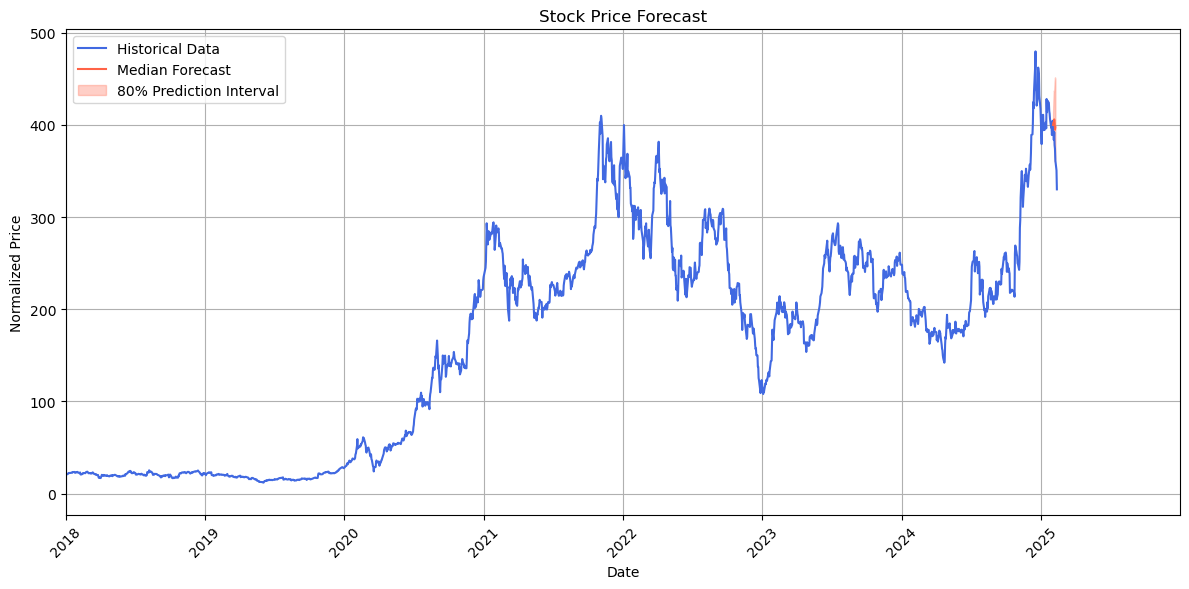

In [77]:
# date range for the forecast
last_date = df['date'].iloc[-1-ctx]
forecast_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1), # start from the day after the last date in the historical data
    periods=prediction_length,
    freq='D'  # daily frequency
)

plt.figure(figsize=(12, 6))
plt.plot(df["date"], df["price"], color="royalblue", label="Historical Data")
plt.plot(forecast_dates, median, color="tomato", label="Median Forecast")
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")

# set x-axis(2010-01-01 ~ 2025-12-31)
plt.xlim([pd.to_datetime('2018-01-01'), pd.to_datetime('2025-12-31')])

plt.title("Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# %pip install sentencepiece

from transformers import T5Tokenizer, T5ForConditionalGeneration

Note: you may need to restart the kernel to use updated packages.


# Split train and testing data

In [46]:
# TSLA_data.head()

GetTSLA = yf.Ticker("TSLA")
TSLA_data=GetTSLA.history(period="max")

train=TSLA_data.loc['2010-06-29':'2024-09-30']
test=TSLA_data.loc['2024-12-01':'2025-05-31']

train.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0


In [47]:
# the number of test, train
print(len(train), len(test))

3588 48


In [49]:
# Pandas Series > Numpy 
context = torch.tensor(train["Close"].values, dtype=torch.float32)

prediction_length = 48

forecast = pipeline.predict(context, prediction_length)


In [56]:
forecast_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1), 
    periods=prediction_length,              
    freq="D"                              
)
print(prediction_length) 


48


In [51]:
# context = torch.tensor(train["price"])
# prediction_length = 48
# forecast = pipeline.predict(context, prediction_length) 

In [57]:
print(forecast_dates)
print(len(forecast_dates))


DatetimeIndex(['2018-07-14 00:00:00-04:00', '2018-07-15 00:00:00-04:00',
               '2018-07-16 00:00:00-04:00', '2018-07-17 00:00:00-04:00',
               '2018-07-18 00:00:00-04:00', '2018-07-19 00:00:00-04:00',
               '2018-07-20 00:00:00-04:00', '2018-07-21 00:00:00-04:00',
               '2018-07-22 00:00:00-04:00', '2018-07-23 00:00:00-04:00',
               '2018-07-24 00:00:00-04:00', '2018-07-25 00:00:00-04:00',
               '2018-07-26 00:00:00-04:00', '2018-07-27 00:00:00-04:00',
               '2018-07-28 00:00:00-04:00', '2018-07-29 00:00:00-04:00',
               '2018-07-30 00:00:00-04:00', '2018-07-31 00:00:00-04:00',
               '2018-08-01 00:00:00-04:00', '2018-08-02 00:00:00-04:00',
               '2018-08-03 00:00:00-04:00', '2018-08-04 00:00:00-04:00',
               '2018-08-05 00:00:00-04:00', '2018-08-06 00:00:00-04:00',
               '2018-08-07 00:00:00-04:00', '2018-08-08 00:00:00-04:00',
               '2018-08-09 00:00:00-04:00', '2018-0